In [98]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Number of rows and columns: (1258, 6)
       Date    Open    High     Low   Close      Volume
0  1/3/2012  325.25  332.83  324.97  663.59   7,380,500
1  1/4/2012  331.27  333.87  329.08  666.45   5,749,400
2  1/5/2012  329.83  330.75  326.89  657.21   6,590,300
3  1/6/2012  328.34  328.77  323.68  648.24   5,405,900
4  1/9/2012  322.04  322.29  309.46  620.76  11,688,800


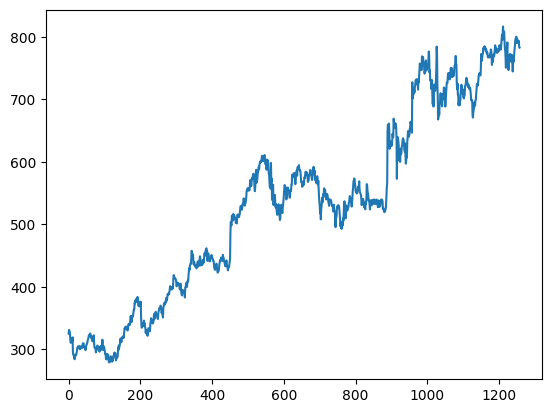

Training data shape: torch.Size([1002, 4, 1]) torch.Size([1002, 1])
Testing data shape: torch.Size([248, 4, 1]) torch.Size([248, 1])
Epoch 0: train RMSE 0.0538, test RMSE 0.0632
Epoch 100: train RMSE 0.0159, test RMSE 0.0191
Epoch 200: train RMSE 0.0153, test RMSE 0.0185
Epoch 300: train RMSE 0.0148, test RMSE 0.0187
Epoch 400: train RMSE 0.0156, test RMSE 0.0219
Epoch 500: train RMSE 0.0149, test RMSE 0.0192
Epoch 600: train RMSE 0.0148, test RMSE 0.0192
Epoch 700: train RMSE 0.0149, test RMSE 0.0194
Epoch 800: train RMSE 0.0150, test RMSE 0.0197
Epoch 900: train RMSE 0.0149, test RMSE 0.0193
Epoch 1000: train RMSE 0.0147, test RMSE 0.0194
Epoch 1100: train RMSE 0.0148, test RMSE 0.0196
Epoch 1200: train RMSE 0.0149, test RMSE 0.0195
Epoch 1300: train RMSE 0.0149, test RMSE 0.0198
Epoch 1400: train RMSE 0.0148, test RMSE 0.0204
Epoch 1500: train RMSE 0.0148, test RMSE 0.0200
Epoch 1600: train RMSE 0.0151, test RMSE 0.0201
Epoch 1700: train RMSE 0.0147, test RMSE 0.0197
Epoch 1800: tra

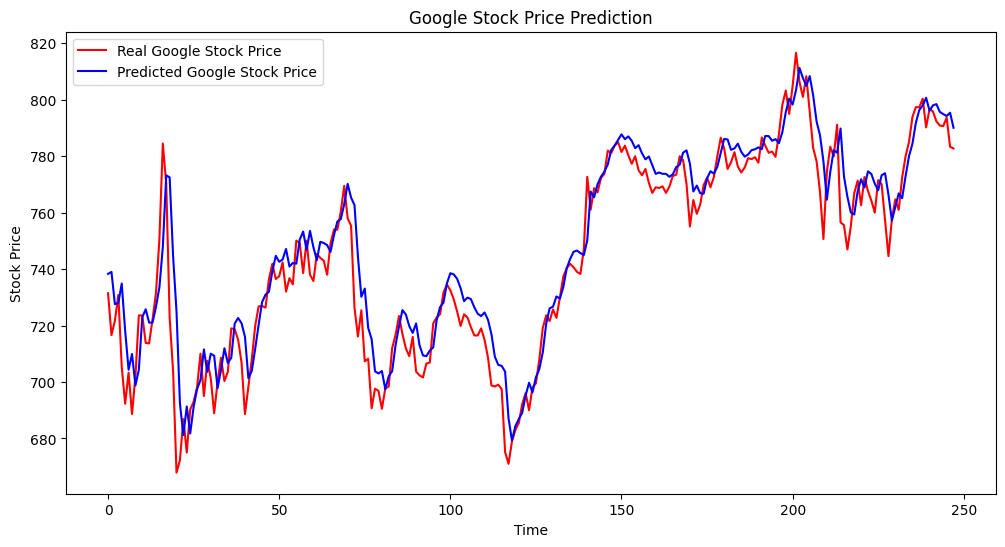

In [183]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Load and prepare data
df = pd.read_csv("/content/drive/MyDrive/Google_Stock_Price_Train-1.csv")
print('Number of rows and columns:', df.shape)
print(df.head(5))

# Select the 'Open' column and convert it to float32
timeseries = df[["Open"]].values.astype('float32')

# Plotting the time series
plt.plot(timeseries)
plt.show()

# Normalize the data to scale between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[['Open']].values)

# Split data into 80% training and 20% testing
train_size = int(len(scaled_data) * 0.8)
training_data, testing_data = scaled_data[:train_size], scaled_data[train_size:]

# Function to create sequences for LSTM
def create_dataset(dataset, lookback):
    X, y = [], []
    for i in range(len(dataset) - lookback):
        feature = dataset[i:i + lookback]
        target = dataset[i + lookback]
        X.append(feature)
        y.append(target)
    return torch.tensor(X).float(), torch.tensor(y).float()

# Set lookback period
lookback = 4

# Create training and testing datasets
X_train, y_train = create_dataset(training_data, lookback=lookback)
X_test, y_test = create_dataset(testing_data, lookback=lookback)

print("Training data shape:", X_train.shape, y_train.shape)
print("Testing data shape:", X_test.shape, y_test.shape)

# Define the LSTM model
class my_LSTM(nn.Module):
    def __init__(self):
        super(my_LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = x[:, -1, :]  # Take only the output of the last time step
        x = self.linear(x)
        return x

model = my_LSTM()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()

# Create DataLoader for training
train_loader = DataLoader(TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

# Train the model
n_epochs = 2000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation every 100 epochs
    if epoch % 100 == 0:
        model.eval()
        with torch.no_grad():
            y_train_pred = model(X_train)
            train_rmse = torch.sqrt(loss_fn(y_train_pred, y_train))
            y_test_pred = model(X_test)
            test_rmse = torch.sqrt(loss_fn(y_test_pred, y_test))
        print(f"Epoch {epoch}: train RMSE {train_rmse:.4f}, test RMSE {test_rmse:.4f}")

# Inverse transform the predictions to get them back to original scale
y_test_pred = y_test_pred.numpy()
y_test = y_test.numpy()
y_test_pred = scaler.inverse_transform(y_test_pred)
y_test = scaler.inverse_transform(y_test)

# Plot the predictions and actual values
plt.figure(figsize=(12, 6))
plt.plot(y_test, color="red", label="Real Google Stock Price")
plt.plot(y_test_pred, color="blue", label="Predicted Google Stock Price")
plt.title("Google Stock Price Prediction")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

In [184]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_test_pred)
print("Mean Absolute Error (MAE):", mae)

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
print("Root Mean Squared Error (RMSE):", rmse)

# Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100
print("Mean Absolute Percentage Error (MAPE):", mape, "%")

Mean Absolute Error (MAE): 8.208565
Root Mean Squared Error (RMSE): 11.659767
Mean Absolute Percentage Error (MAPE): 1.1198206804692745 %


The objective of this project was to build an LSTM model to predict Google’s stock price based on historical data. The data was split into 80% for training and 20% for testing. Only the ‘Open’ price was used for predictions, normalized to a range of 0 to 1 using a MinMaxScaler for more efficient training. The model was designed to predict the next day’s stock price based on sequences of the previous 4 days. This architecture aimed to capture temporal patterns in the stock price through a single-layer LSTM with 50 hidden units and a fully connected dense layer for the final prediction. A dropout rate of 0.1 was applied to reduce the risk of overfitting, and the Mean Squared Error (MSE) was used as the loss function with the Adam optimizer.

The model was trained over 2000 epochs with a batch size of 8, validating every 100 epochs. To evaluate the model’s performance on the test data, three metrics were used: Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), and Mean Absolute Percentage Error (MAPE). The model achieved an MAE of 8.40, an RMSE of 11.94, and a MAPE of 1.15%. These values indicate a strong predictive performance, with low average error and deviations, and an error percentage of only 1.15% relative to the actual stock price, which underscores the model’s ability to accurately capture trends.

A visualization of the predicted versus actual stock prices confirmed the model’s effectiveness, showing that the predictions closely followed the actual stock price trend. This graph highlights the LSTM model’s capacity to track fluctuations and align with real stock prices over time. Overall, the model performed well, achieving accurate predictions with minimal error. This project demonstrates that, with sufficient historical data and optimized architecture, LSTM models can effectively capture stock price trends, suggesting potential for further applications or refinements in predictive financial modeling.